In [1]:
import optuna
import subprocess
import json
import shutil
import os
from train import main as train_main

def objective(trial):
    # パラメータの提案
    hidden_size = trial.suggest_categorical("hidden_size", [4, 3, 2, 1])
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    episodes = trial.suggest_int("episodes", 100, 300, step=20)  # 100, 110, 120, ...
    
    # モデルパスの定義
    model_path = f"save/model_trial_{trial.number}_h{hidden_size}_lr{lr:.5f}_g{gamma:.3f}.pth"

    # 訓練スタート
    train_main(
        lr=lr,
        gamma=gamma,
        hidden_size=hidden_size,
        episodes=episodes,
        save_path=model_path  # ←動的に渡す！
    )
    
    # パスを trial に記録
    trial.set_user_attr("model_path", model_path)
    
    # 訓練結果を保存
    result = subprocess.run(["python", "inference.py", model_path], capture_output=True, text=True)
    # デバッグ出力を追加！
    print("STDOUT:\n", result.stdout)
    print("STDERR:\n", result.stderr)

    distance = float(result.stdout.strip())
    return distance

In [2]:
# 最適化開始
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, show_progress_bar=True)
best_model_path = study.best_trial.user_attrs["model_path"]
# 結果表示
print("Best trial:")
print(study.best_trial)
print("Best model path:", best_model_path)

[I 2025-04-18 13:59:38,577] A new study created in memory with name: no-name-64066376-85ae-4828-9b11-6541cbbcbf70


  0%|          | 0/1 [00:00<?, ?it/s]

STDOUT:
 1015.7479453861405

STDERR:
 
[I 2025-04-18 14:00:12,210] Trial 0 finished with value: 1015.7479453861405 and parameters: {'hidden_size': 1, 'gamma': 0.9112260045605551, 'lr': 0.00753082916765505, 'episodes': 100}. Best is trial 0 with value: 1015.7479453861405.
Best trial:
FrozenTrial(number=0, state=1, values=[1015.7479453861405], datetime_start=datetime.datetime(2025, 4, 18, 13, 59, 38, 581902), datetime_complete=datetime.datetime(2025, 4, 18, 14, 0, 12, 210226), params={'hidden_size': 1, 'gamma': 0.9112260045605551, 'lr': 0.00753082916765505, 'episodes': 100}, user_attrs={'model_path': 'save/model_trial_0_h1_lr0.00753_g0.911.pth'}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': CategoricalDistribution(choices=(4, 3, 2, 1)), 'gamma': FloatDistribution(high=0.99, log=False, low=0.9, step=None), 'lr': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'episodes': IntDistribution(high=300, log=False, low=100, step=20)}, trial_id=0, value=None

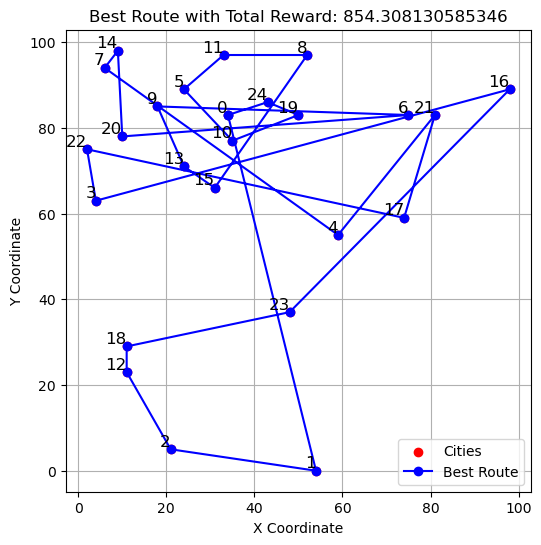

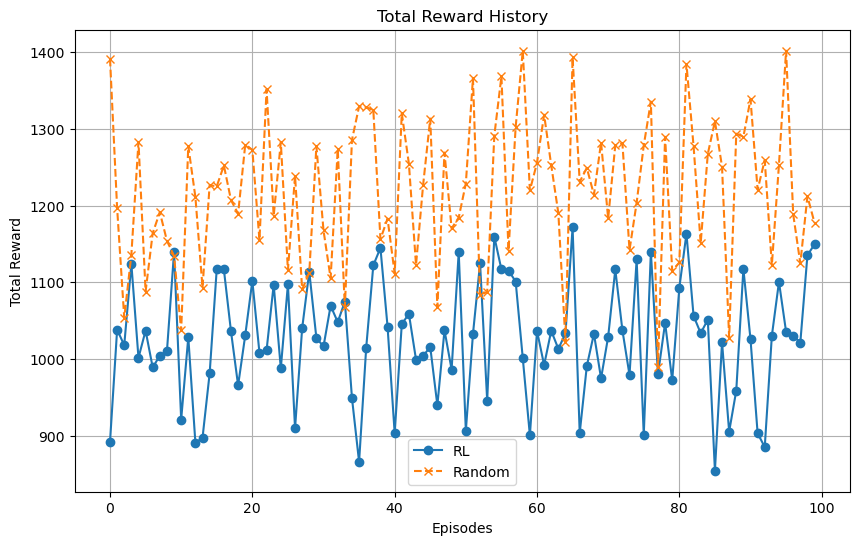

1025.9796744663101


In [3]:
from inference import main as inference_main

# best モデルでプロットしたい場合
inference_main(best_model_path, episodes=100, plot=True)
